In [21]:
import pandas as pd
import plotly.express as px
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab
import copy
import scipy.stats as stats
from statsmodels.compat import lzip
from sklearn import preprocessing
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white

In [22]:
df = pd.read_table("flatfiles/spider_wolff_gorb_2013.csv", sep=",", skiprows=1)

In [23]:
px.box(df, x='type', y='friction', color='leg')

In [24]:
df

,leg,type,friction
0,L1,pull,0.90
1,L1,pull,0.91
2,L1,pull,0.86
3,L1,pull,0.85
4,L1,pull,0.80
...,...,...,...
277,L4,push,0.20
278,L4,push,0.24
279,L4,push,0.21
280,L4,push,0.17


In [25]:
d = copy.deepcopy(df)

In [26]:
a = d.unstack(level=-1)

In [28]:
a

leg       0        L1
          1        L1
          2        L1
          3        L1
          4        L1
                 ... 
friction  277     0.2
          278    0.24
          279    0.21
          280    0.17
          281    0.27
Length: 846, dtype: object

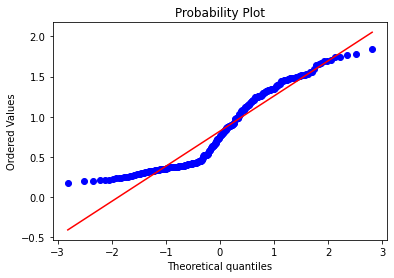

In [29]:
stats.probplot(np.array(df['friction'].to_list()), dist="norm", plot=pylab)
pylab.show()

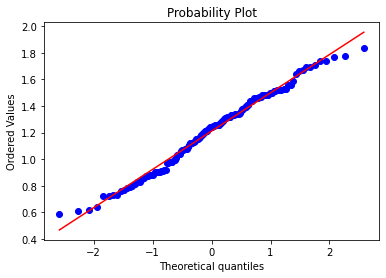

In [30]:
stats.probplot(np.array(df[df['type']=='pull']['friction'].to_list()), dist="norm", plot=pylab)
pylab.show()

In [31]:
px.histogram(df[df['type']=='pull']['friction'].to_list())

In [32]:
y, X = dmatrices('friction ~ type + leg', df, return_type='dataframe')

In [33]:
px.imshow(X)

In [34]:
y, X = dmatrices('friction ~ type * leg', df, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               friction   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     188.3
Date:                Fri, 27 Aug 2021   Prob (F-statistic):          8.56e-101
Time:                        21:40:39   Log-Likelihood:                 71.598
No. Observations:                 282   AIC:                            -127.2
Df Residuals:                     274   BIC:                            -98.06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

In [35]:
mod = smf.ols(formula='friction ~ type * leg', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               friction   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     188.3
Date:                Fri, 27 Aug 2021   Prob (F-statistic):          8.56e-101
Time:                        21:40:40   Log-Likelihood:                 71.598
No. Observations:                 282   AIC:                            -127.2
Df Residuals:                     274   BIC:                            -98.06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

In [36]:
#from the design matrix can pull out individual contrasts
tt = res.t_test("type[T.push]:leg[T.L3] - type[T.push]:leg[T.L2]")

In [37]:
tt

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.2799      0.079     -3.546      0.000      -0.435      -0.124

In [38]:
sm.stats.anova_lm(res, typ=2) 

,sum_sq,df,F,PR(>F)
type,42.783070,1.0,1179.712763,2.753680e-101
leg,2.920856,3.0,26.846842,2.971903e-15
type:leg,2.097865,3.0,19.282380,2.255560e-11
Residual,9.936793,274.0,NaN,NaN


In [60]:
#type is very useful (reduces the sum of squared residuals compared to a model with only intercept)
#NOTE: this is the reduction from the addition of the term from the previous row
#F-value is the mean of squares

In [ ]:
mod = smf.ols(formula='friction ~ type * leg', data=df)
res = mod.fit()
print(res.summary())

In [78]:
mod = smf.ols(formula='friction ~ 0 + leg + type', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               friction   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     263.0
Date:                Sun, 22 Aug 2021   Prob (F-statistic):           5.26e-93
Time:                        19:00:52   Log-Likelihood:                 44.590
No. Observations:                 282   AIC:                            -79.18
Df Residuals:                     277   BIC:                            -60.97
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
leg[L1]          1.0539      0.028     37.426   

In [39]:
y, X = dmatrices('friction ~ 0 + leg * type', df, return_type='dataframe')
px.imshow(X)

In [40]:
#test to see if there is heteroscedasticity in the fit
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
white_test = het_white(res.resid, res.model.exog)
breusch_test = het_breuschpagan(res.resid, res.model.exog)

In [41]:
het_breuschpagan

<function statsmodels.stats.diagnostic.het_breuschpagan(resid, exog_het, robust=True)>

In [42]:
#null hyothesis rejected (p-value <= 0.05) thus we can state that the data is heteroscedastic
lzip(names, breusch_test)

[('Lagrange multiplier statistic', 35.56727968068678),
 ('p-value', 8.747379371247825e-06),
 ('f-value', 5.649432208909717),
 ('f p-value', 4.1647854980722486e-06)]

In [43]:
df

,leg,type,friction
0,L1,pull,0.90
1,L1,pull,0.91
2,L1,pull,0.86
3,L1,pull,0.85
4,L1,pull,0.80
...,...,...,...
277,L4,push,0.20
278,L4,push,0.24
279,L4,push,0.21
280,L4,push,0.17
